In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.ts_utils import * 
from scripts.python.tsmodel import * 
from scripts.python.ts_eval import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
filedir = os.getcwd() + "/data/tourism/palau/intermediate/"
modeldir = os.getcwd() + "/data/tourism/palau/model/"
filepaths = [filedir + file for file in os.listdir(filedir) if ".csv" in file]
filepaths

['/Users/czhang/Desktop/pacific-observatory/data/tourism/palau/intermediate/palau_merged.csv',
 '/Users/czhang/Desktop/pacific-observatory/data/tourism/palau/intermediate/palau_monthly_visitor.csv']

## Preprocessing
### Use `stringency_index` as a proxy

In [3]:
covid_data = pd.read_csv(os.getcwd() + "/data/tourism/owid-covid-data.csv")

# There is no Palau's stringency index, using Oceania's mean as the proxy
oceania_covid = (covid_data[covid_data.continent == "Oceania"]
                 .reset_index()
                 .drop("index", axis=1))
oceania_index = oceania_covid[["date", "location", "stringency_index"]]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])
oceania_index = oceania_index.groupby("date").mean().reset_index()
oceania_index.head(5)

,date,stringency_index
0,2020-01-26,5.560
1,2020-01-27,5.560
2,2020-01-28,5.560
3,2020-01-29,5.560
4,2020-01-30,8.335


In [4]:
oceania_index["year"], oceania_index["month"] = \
    oceania_index["date"].dt.year, oceania_index["date"].dt.month
oceania_index = oceania_index.groupby(["year", "month"]).mean().reset_index()
oceania_index["date"] = [str(year) + "-" + str(month)
                         for year, month in zip(oceania_index.year, oceania_index.month)]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])

In [5]:
oceania_index.to_csv(
    os.getcwd() + "/data/tourism/oceania_covid_stringency.csv", encoding="utf-8")
oceania_index.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


In [6]:
gt = pd.read_csv(os.getcwd() + "/data/tourism/trends/trends_palau.csv").drop("Unnamed: 0", axis=1)
gt["date"] = pd.to_datetime(gt["date"])
gt.head(5)

,date,palau flights-AU,palau hotel-AU,palau travel-AU,palau flights-NZ,palau hotel-NZ,palau travel-NZ,palau flights-US,palau hotel-US,palau travel-US,...,palau travel-JP,palau flights-HK,palau hotel-HK,palau travel-HK,palau flights-NC,palau hotel-NC,palau travel-NC,palau flights,palau hotel,palau travel
0,2004-01-01,0,0,0,0,0,0,0,23,0,...,0,0,0,0,0,0,0,0.0,3.155717,3.055298
1,2004-02-01,0,0,0,0,0,0,0,0,28,...,0,0,0,0,0,0,0,0.0,5.111154,2.142547
2,2004-03-01,0,63,0,0,0,0,0,0,0,...,0,0,90,0,0,0,0,0.0,6.132983,2.768303
3,2004-04-01,0,0,0,0,0,0,0,0,100,...,0,0,0,0,0,0,0,0.0,10.537711,0.000000
4,2004-05-01,0,0,0,0,0,0,22,0,0,...,0,0,0,0,0,0,0,0.0,7.344062,0.000000


### Read Palau's intermediate files

In [7]:
palau = pd.read_csv(filepaths[-1]).drop("Unnamed: 0", axis=1)
palau["Date"] = pd.to_datetime(palau["Date"])
palau = (palau.merge(gt[["date", "palau travel"]], left_on="Date", right_on="date")
         .merge(oceania_index, how="left", on="date")
              .drop("date", axis=1)
         .fillna(0)
         .rename({"stringency_index": "covid",
                  "palau travel": "palau_travel"}, axis=1))
palau.to_csv(modeldir + "palau_for_utsa.csv", encoding="utf-8")
palau.head(5)

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,palau_travel,year,month,covid
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.320004,0.0,0.0,0.0
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.952482,0.0,0.0,0.0
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.453967,0.0,0.0,0.0
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.000000,0.0,0.0,0.0
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.000000,0.0,0.0,0.0


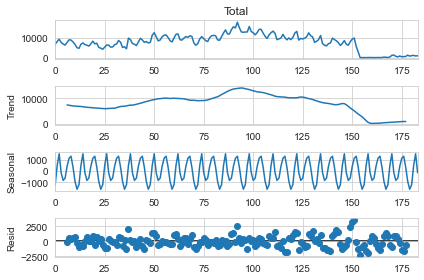

In [8]:
decompose = seasonal_decompose(palau["Total"], period=12, model="additive")
f = decompose.plot()
plt.rcParams.update({'figure.figsize': (10, 9)})

## SARIMAX

In [9]:
naive_pred = naive_method(palau["Total"])
mean_pred = mean_method(palau["Total"])
snaive_pred = seasonal_naive_method(palau["Total"])

benchmark = pd.DataFrame()
for idx, pred in enumerate([naive_pred, mean_pred, snaive_pred]):
    metrics = calculate_evaluation(palau["Total"], pred)
    metrics_df = pd.DataFrame(metrics, index=[idx])
    benchmark = pd.concat([benchmark, metrics_df], axis=0)

benchmark.index = ["naive", "mean", "seasonal naive"]
benchmark

,MSE,RMSE,MAE,MAPE
naive,2.096767e+06,1448.021907,1092.759563,323.392324
mean,1.639656e+07,4049.266859,3178.648757,8859.425305
seasonal naive,1.123704e+07,3352.169852,2405.935201,8120.993038


### Transformation & Train-Test Split

[Scaled Logit Transformation](https://otexts.com/fpp3/limits.html#forecasts-constrained-to-an-interval):
$$y = \log\left(\frac{x-a}{b-x}\right)$$
and Inverse Transformation is: 
$$ x  = \frac{(b-a)e^y}{1+e^y} + a $$


In [10]:
ps = SARIMAXPipeline(data=palau, y_var="Total", exog_var=["covid", "palau_travel"], transform_method="scaledlogit")
ps.transform()

training size : 165, testing size : 19


<AxesSubplot:>

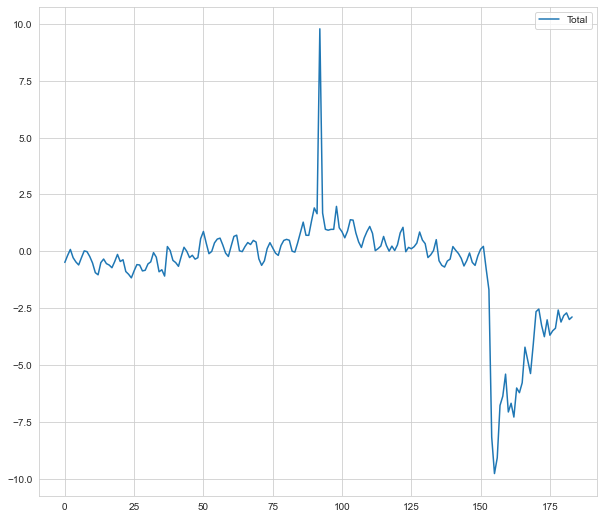

In [11]:
ps.transformed_y.plot()

### Stepwise searching

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=495.109, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=494.742, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=480.126, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=461.639, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=492.765, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=463.008, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=462.007, Time=0.49 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=460.759, Time=0.10 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=460.706, Time=0.31 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=455.893, Time=0.57 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=455.893, Time=0.74 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=45

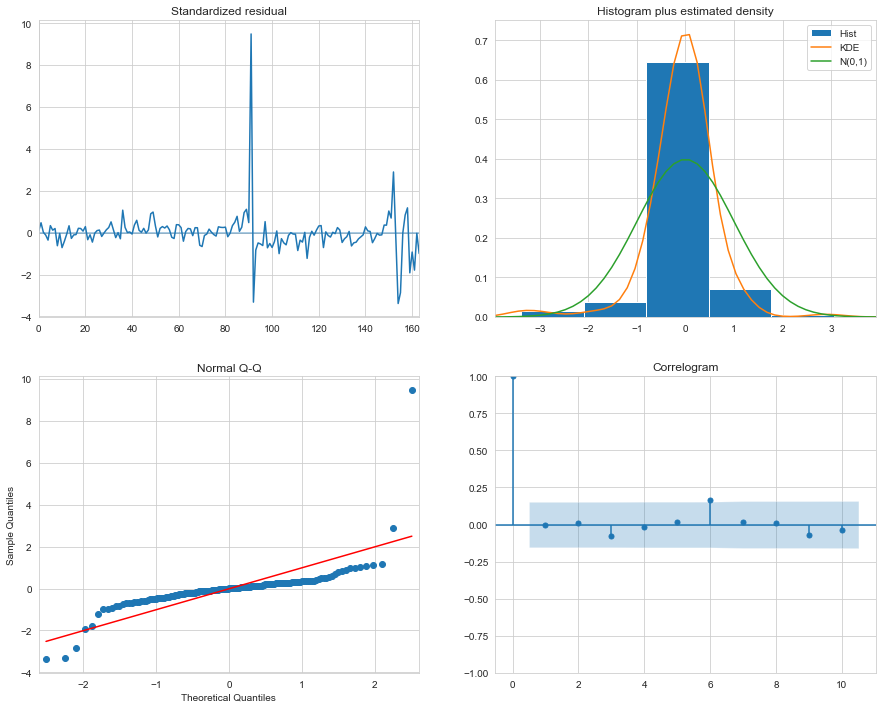

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [12]:
ps.stepwise_search()

### Manually Searching

In [13]:
# Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

# Search the minimim aic
ps_msres = ps.manual_search(params=all_param)

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:504.6
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:494.47
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:493.57
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:511.9
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:481.05
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:481.04
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:491.4
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:491.79
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:493.74
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:492.37
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:479.33
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:480.44
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:491.94
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:493.75
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:492.19
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:486.38
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:480.19
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:480.76
Tried out SARIMAX(0, 0, 1)x(0, 

Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:451.32
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:463.1
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:435.43
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:436.39
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:452.61
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:451.45
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:452.3
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:453.0
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:437.4
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:438.3
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:480.38
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:479.01
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:479.59
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:510.98
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:450.88
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:452.8
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:478.18
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:470.59
Tried out SARIMAX(1, 1, 0)x(1, 0, 

Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:439.69
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:452.34
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:454.47
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:455.48
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:493.19
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:436.21
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:438.21
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:453.7
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:450.85
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:452.92
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:466.42
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:438.23
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:439.14
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:454.62
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:452.96
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:454.15
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:456.41
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:439.95
Tried out SARIMAX(2, 1, 2)x(2

### Cross-validation

In [14]:
ps_msres.sort(key=lambda x: x[1])
ps_msres[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2c65f0430>,
  432.68888495682086,
  ((1, 1, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2c1308970>,
  432.93160791603253,
  ((0, 1, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2c7c59430>,
  433.17575617896273,
  ((2, 0, 1), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2b5c3fa60>,
  433.44075761136975,
  ((1, 0, 2), (0, 1, 1, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2b76a3a00>,
  433.53037066641303,
  ((0, 1, 1), (0, 1, 1, 12)))]

In [15]:
ps_models = []
ps_sw = ps.stepwise_model
ps_models.append(pm.ARIMA(
    ps_sw["order"], ps_sw["seasonal_order"],  exog=ps.exog[:ps.training_size]))
for res in ps_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=ps.exog[:ps.training_size])
    ps_models.append(model)

ps.comp = ps.compare_models(
    y=ps.transformed_y[:ps.training_size],
    exog=ps.exog[:ps.training_size],
    models=ps_models)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] f

In [16]:
ps.comp

{'model': [ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([106.84907584,  69.17575204,  59.46283951,  93.92695356,
          91.5328029 , 163.31470591, 148.64533213, 167.10137747,
         180.91158619, 170.76577203, 172.62822017, 196.87461592,
         115.32507484,  53.36791049, 129.09521683, 193.60380046,
         121.16344171, 154.82443827, 154.7316949 , 138.35118655,
         114.29133923,  83.75223643, 182.02682155, 181.76198728]),
  array([ 59.46083747,  48.5008139 ,  54.62415759, 103.28969877,
         118.10870816, 161.92650478, 126.07084679, 101.90918207,
          88.43730345, 106.07581107, 171.83034237, 191.08560152,
         131.56954299,  51.33194005,  79.52073519,  62

### Best Logit Scaled Model

In [17]:
best_ps = ps_msres[1][0]
best_ps.save(filedir + "best_scaled.pkl")
best_ps_mod = ps.get_prediction_df(
    best_ps, 19, ps.exog[-ps.test_size:])
lower = palau["Total"].min() - 1
upper = palau["Total"].max() + 1

for col_idx, col in enumerate(best_ps_mod.columns):
    for row_idx, _ in enumerate(best_ps_mod[col]):
        best_ps_mod.iloc[row_idx, col_idx] = ps.inverse_scaledlogit(
            best_ps_mod.iloc[row_idx, col_idx], upper, lower)

In [18]:
best_ps_mod = pd.concat([palau[["Date", "Total"]], best_ps_mod], axis=1)
best_ps_mod.head(20)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,9013.192125,NaN,0.000000,NaN,NaN
1,2007-07-01,8021.0,7003.843791,NaN,0.000000,NaN,NaN
2,2007-08-01,9196.0,7778.963187,NaN,0.000000,NaN,NaN
3,2007-09-01,7595.0,8973.138334,NaN,0.000000,NaN,NaN
4,2007-10-01,6795.0,7595.000823,NaN,0.000000,NaN,NaN
5,2007-11-01,6252.0,7027.822925,NaN,0.000000,NaN,NaN
6,2007-12-01,7595.0,6030.373916,NaN,0.000000,NaN,NaN
7,2008-01-01,8911.0,8012.752149,NaN,0.000000,NaN,NaN
8,2008-02-01,8766.0,8752.432851,NaN,0.000000,NaN,NaN
9,2008-03-01,7817.0,9456.396154,NaN,0.000000,NaN,NaN


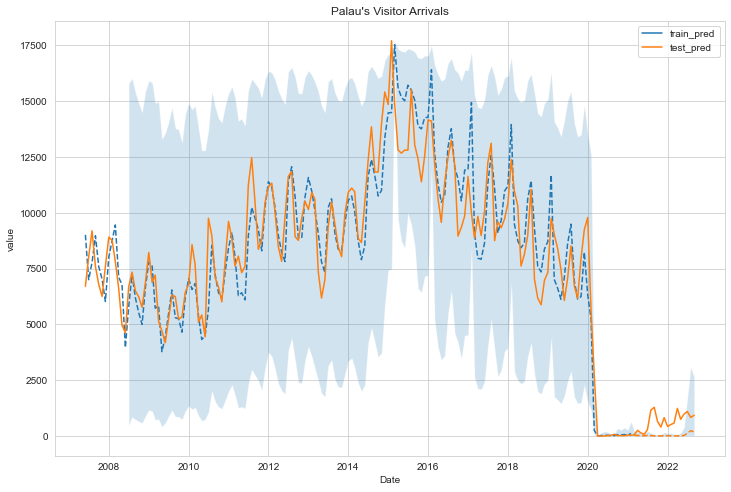

In [19]:
sclaed_viz_df = best_ps_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])
sclaed_viz_df["Date"] = pd.to_datetime(sclaed_viz_df["Date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", data=best_ps_mod, alpha=0.2)
sns.lineplot(data=sclaed_viz_df, x="Date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=best_ps_mod, x="Date", y="Total")
plt.title("Palau's Visitor Arrivals")
plt.show()

In [20]:
pred_series = best_ps_mod["train_pred"].fillna(0) + best_ps_mod["test_pred"].fillna(0)
sl_eval = pd.DataFrame(calculate_evaluation(palau["Total"], pred_series), index=["scaled logit"])
sl_eval

,MSE,RMSE,MAE,MAPE
scaled logit,1.665192e+06,1290.423192,956.51639,47.330844


### Best No-Transformation Models (existence of negative values)

training size : 165, testing size : 19
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2837.635, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2865.791, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2822.976, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2838.728, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2863.842, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2867.193, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2813.946, Time=0.38 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2800.378, Time=0.68 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2797.803, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2839.224, Time=0.14 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2811.337, Time=0.74 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2833.873, Time=0.52 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time

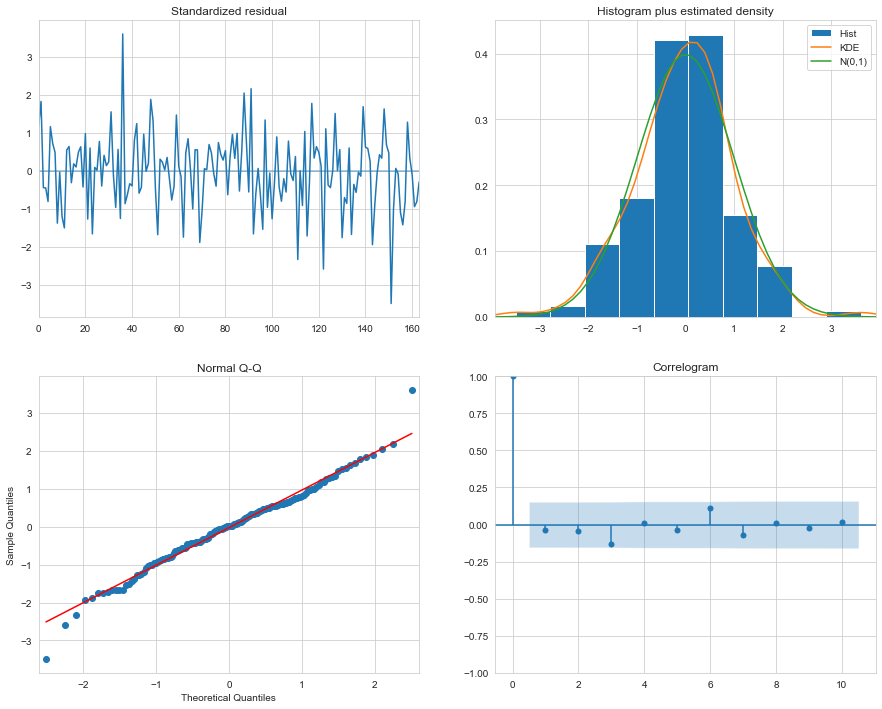

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:3299.95
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:3264.02
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:3256.79
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:2794.96
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:2790.67
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:2792.19
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:3042.78
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:3235.7
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:3258.89
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:2792.26
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:2794.74
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:2786.95
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:3232.63
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:3236.81
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:3241.71
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:2790.81
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:2784.76
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:2791.24
Tried out S

Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:3168.08
Tried out SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:3191.63
Tried out SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:3193.51
Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:2644.54
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:2628.11
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:2628.35
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:3191.92
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:3193.54
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:3194.45
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:2627.94
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:2628.11
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:2629.45
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:2865.23
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:2837.3
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:2831.96
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:2647.04
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:2583.1
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:2584.09
Tried out SA

Tried out SARIMAX(2, 1, 1)x(2, 0, 0, 12) - AIC:2805.65
Tried out SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC:2798.13
Tried out SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:2797.19
Tried out SARIMAX(2, 1, 1)x(2, 1, 0, 12) - AIC:2593.02
Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:2593.17
Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:2591.52
Tried out SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:2800.62
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:2797.85
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:2799.83
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:2642.65
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:2591.72
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:2592.27
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:2797.68
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:2794.02
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:2797.53
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:2619.1
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:2592.73
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:2586.75
Tried out S

In [21]:
po = SARIMAXPipeline(data=palau, y_var="Total", exog_var=["covid", "palau_travel"], transform_method=None)
po.transform()
po_sw = po.stepwise_search()
po_msres = po.manual_search(params=all_param)
po_msres.sort(key=lambda x: x[1])

po_models = []
po_models.append(pm.ARIMA(
    po_sw["order"], po_sw["seasonal_order"],  exog=po.exog[:po.training_size]))

for res in po_msres[:5]:
    order, seasonal_order = res[-1]
    model = pm.ARIMA(order, seasonal_order, exog=po.exog[:po.training_size])
    po_models.append(model)

In [22]:
ps_comp = po.compare_models(y=po.transformed_y[:po.training_size],
                            exog=po.exog[:po.training_size], models=po_models[1:])

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

In [23]:
ps_comp

{'model': [ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([ 35.49179795,  38.84791079,  37.32626431,  20.95678051,
          23.22776158,  10.55611214,  26.37808059,  32.77661478,
          36.11462914,  47.39987106,  17.59770811,  12.49576708,
          10.75281395,  37.59799777,  50.10112223,  40.26554052,
          39.97080604,  36.93607326,  29.12273258,  48.39435322,
          47.80023115,  28.95004809,  74.98447146, 154.45266909]),
  array([ 35.49179795,  38.84791079,  37.32626431,  20.95678051,
          23.22776158,  10.55611214,  26.37808059,  32.77661478,
          36.11462914,  47.39987106,  17.59770811,  12.49576708,
          10.75281395,  37.59799777,  50.10112223,  40.26554052,
          39.97080604,  36.93607326,  29.1227

In [24]:
best_original = po_msres[5][0]
best_original.save(filedir+"best_original.pkl")
original_mod = po.get_prediction_df(best_original, steps=po.test_size, exog=po.exog[-po.test_size:])
original_mod.columns.name = None
original_mod = pd.concat([palau[["Date", "Total"]], original_mod], axis=1)
original_mod.head(5)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,162.159276,2021.081236,-3799.087156,4123.405708,NaN
1,2007-07-01,8021.0,6247.398438,1739.676419,2837.695312,9657.101564,NaN
2,2007-08-01,9196.0,7109.101021,1727.733821,3722.804958,10495.397084,NaN
3,2007-09-01,7595.0,8467.487871,1725.007649,5086.535006,11848.440736,NaN
4,2007-10-01,6795.0,7593.586296,1724.715898,4213.205253,10973.967338,NaN


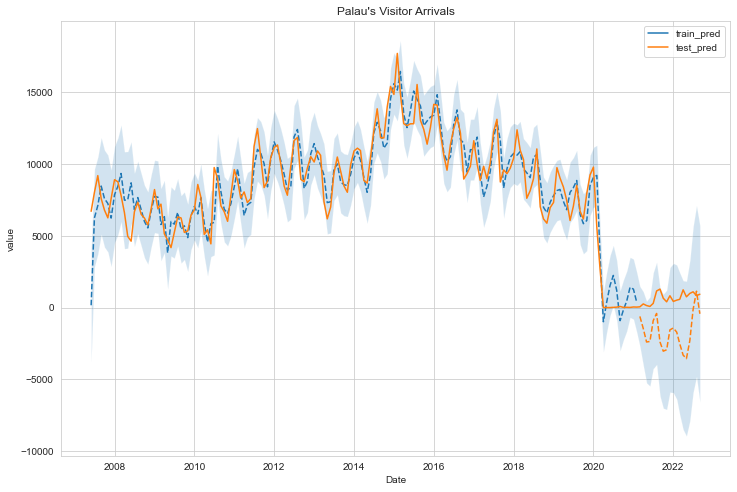

In [25]:
original_viz_df = original_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", data=original_mod, alpha=0.2)
sns.lineplot(data=original_viz_df, x="Date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=original_mod, x="Date", y="Total")
plt.title("Palau's Visitor Arrivals")
plt.show()

In [26]:
org_pred = original_mod["train_pred"].fillna(0) + original_mod["test_pred"].fillna(0)
org_eval = pd.DataFrame(calculate_evaluation(palau["Total"], org_pred), index=["original"])
model_eval = pd.concat([sl_eval, org_eval], axis=0)
model_eval = pd.concat([benchmark, model_eval])
model_eval.to_csv(modeldir + "model_eval.csv", encoding="utf-8")
model_eval

,MSE,RMSE,MAE,MAPE
naive,2.096767e+06,1448.021907,1092.759563,323.392324
mean,1.639656e+07,4049.266859,3178.648757,8859.425305
seasonal naive,1.123704e+07,3352.169852,2405.935201,8120.993038
scaled logit,1.665192e+06,1290.423192,956.516390,47.330844
original,2.194218e+06,1481.289413,1096.941569,994.420035


## VARMAX

In [27]:
scaled_logit = SARIMAXPipeline.scaledlogit_transform
inverse_transform = SARIMAXPipeline.inverse_scaledlogit

In [28]:
palau_merged = pd.read_csv(filepaths[0]).drop(["Unnamed: 0", "Date"], axis=1)
palau_merged["date"] = [str(year) + '-' + str(month)
                        for year, month in zip(palau_merged.Year, palau_merged.Month)]
palau_merged["date"] = pd.to_datetime(palau_merged["date"])
palau_merged = (palau_merged.merge(oceania_index, how="left", on="date")
                .merge(gt.iloc[:, [0, -3, -2, -1]], how="left", on="date")
                .drop(["year", "month"], axis=1)
                .fillna(0))
palau_merged["covid"] = (palau_merged["date"] >= "2020-03-12").astype(int)
palau_merged.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,Number_of_flights_intl,Number_of_flights_total,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,date,stringency_index,palau flights,palau hotel,palau travel,covid
0,2019,1,13048.0,13048.0,75.0,75.0,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0,2019-01-01,0.0,0.493228,2.559978,0.194222,0
1,2019,2,13281.0,13281.0,74.0,74.0,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0,2019-02-01,0.0,0.310671,2.841414,0.282245,0
2,2019,3,12870.0,12870.0,73.0,73.0,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0,2019-03-01,0.0,0.386389,2.921431,0.286529,0
3,2019,4,10806.0,10806.0,64.0,64.0,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0,2019-04-01,0.0,0.293529,2.981907,0.338945,0
4,2019,5,11472.0,11472.0,67.0,67.0,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0,2019-05-01,0.0,0.306351,3.537987,0.168664,0


In [29]:
palau_merged.columns = [col.replace(" ", "_").lower() for col in palau_merged.columns]
palau_merged.head(5)

,year,month,seats_arrivals_intl,seats_arrivals_total,number_of_flights_intl,number_of_flights_total,japan,south_korea,taiwan,china,usa/canada,europe,others,total,date,stringency_index,palau_flights,palau_hotel,palau_travel,covid
0,2019,1,13048.0,13048.0,75.0,75.0,1953.0,1169.0,919.0,2072.0,626.0,310.0,280.0,7329.0,2019-01-01,0.0,0.493228,2.559978,0.194222,0
1,2019,2,13281.0,13281.0,74.0,74.0,2055.0,1035.0,1092.0,4059.0,702.0,438.0,371.0,9752.0,2019-02-01,0.0,0.310671,2.841414,0.282245,0
2,2019,3,12870.0,12870.0,73.0,73.0,2434.0,1090.0,1190.0,2549.0,826.0,483.0,461.0,9033.0,2019-03-01,0.0,0.386389,2.921431,0.286529,0
3,2019,4,10806.0,10806.0,64.0,64.0,1756.0,808.0,1099.0,3182.0,777.0,368.0,415.0,8405.0,2019-04-01,0.0,0.293529,2.981907,0.338945,0
4,2019,5,11472.0,11472.0,67.0,67.0,1288.0,1095.0,1393.0,2489.0,607.0,185.0,421.0,7478.0,2019-05-01,0.0,0.306351,3.537987,0.168664,0


In [30]:
test_cols = ["seats_arrivals_intl", "total", "palau_travel"]
get_adf_df(palau_merged, test_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
seats_arrivals_intl,-2.011353,0.281617,2.0,42.0,-3.596636,-2.933297,-2.604991
total,-1.838074,0.361729,6.0,38.0,-3.615509,-2.941262,-2.609200
palau_travel,-2.547037,0.104445,4.0,40.0,-3.605565,-2.937069,-2.606986


In [31]:
palau_diff = palau_merged[test_cols].diff().dropna()
get_adf_df(palau_diff, test_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
seats_arrivals_intl,-5.476862,0.000002,0.0,43.0,-3.592504,-2.931550,-2.604066
total,-2.622492,0.088437,5.0,38.0,-3.615509,-2.941262,-2.609200
palau_travel,-5.085595,0.000015,3.0,40.0,-3.605565,-2.937069,-2.606986


In [32]:
palau_diff2 = palau_diff.diff().dropna()
get_adf_df(palau_diff2, test_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
seats_arrivals_intl,-10.686152,3.828714e-19,0.0,42.0,-3.596636,-2.933297,-2.604991
total,-4.001045,1.405051e-03,6.0,36.0,-3.626652,-2.945951,-2.611671
palau_travel,-5.139137,1.168912e-05,5.0,37.0,-3.620918,-2.943539,-2.610400


### Unscaled

In [55]:
varmax_exog = palau_merged[["covid", "stringency_index"]].to_numpy()
varma_search(palau_diff, ["total", "seats_arrivals_intl",
             "palau_travel"], varmax_exog[1:])

 Running for {'p': 1, 'q': 1, 'tr': 'n'}
 Running for {'p': 1, 'q': 1, 'tr': 'c'}


KeyboardInterrupt: 

In [178]:
varma_ns = VARMAX(endog=palau_diff[["total", "seats_arrivals_intl", "palau_travel"]],
               exog=varmax_exog[1:], order=(1, 2), tr="c")
varma_ns_res = varma_ns.fit(disp=False)
varma_ns_res.summary()

Dep. Variable:,"['total', 'seats_arrivals_intl', 'palau_travel']",No. Observations:,44
Model:,"VARMAX(1,2)",Log Likelihood,-680.797
,+ intercept,AIC,1445.594
Date:,"Fri, 07 Apr 2023",BIC,1520.530
Time:,16:53:23,HQIC,1473.384
Sample:,0,,
,- 44,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.23, 0.02, 0.23",Jarque-Bera (JB):,"26.76, 58.13, 0.34"
Prob(Q):,"0.63, 0.89, 0.63",Prob(JB):,"0.00, 0.00, 0.84"
Heteroskedasticity (H):,"0.16, 0.18, 0.97",Skew:,"-0.71, -1.66, 0.20"


### Scaled Logit

In [188]:
varma_cols = ["total", "seats_arrivals_intl", "palau_travel"]
for col in varma_cols[:2]:
    palau_merged["sl_"+str(col)] = scaled_logit(palau_merged[col])

In [120]:
varma = VARMAX(endog=palau_merged["sl_total", "sl_seats_arrivals_intl", "palau_travel"],
               exog=varmax_exog, order=(1, 1), tr="ct")
varma_res = varma.fit(disp=False)
varma_res.summary()

Dep. Variable:,"['sl_total', 'sl_seats_arrivals_intl', 'palau_travel']",No. Observations:,45
Model:,"VARMAX(1,1)",Log Likelihood,-112.196
,+ intercept,AIC,290.393
Date:,"Thu, 06 Apr 2023",BIC,350.013
Time:,15:47:20,HQIC,312.618
Sample:,0,,
,- 45,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.48, 0.31, 0.37",Jarque-Bera (JB):,"35.34, 24.94, 1.79"
Prob(Q):,"0.22, 0.58, 0.54",Prob(JB):,"0.00, 0.00, 0.41"
Heteroskedasticity (H):,"0.26, 0.07, 0.91",Skew:,"1.22, -0.04, 0.39"


In [123]:
total_pred = varma_res.get_prediction().summary_frame()
total_pred.columns.name = None

In [115]:
for col in ["total", "seats_arrivals_intl"]:
    palau_merged["sl_" + col] = scaled_logit(palau_merged[col])
    
varmax_exog = palau_merged[["covid", "stringency_index"]].to_numpy()

In [132]:
lower = palau_merged["total"].min() - 1
upper = palau_merged["total"].max() + 1

inv_lst = []
for val in total_pred["mean"]:
    inv_lst.append(inverse_transform(val, upper, lower))
palau_merged["mean"] = inv_lst

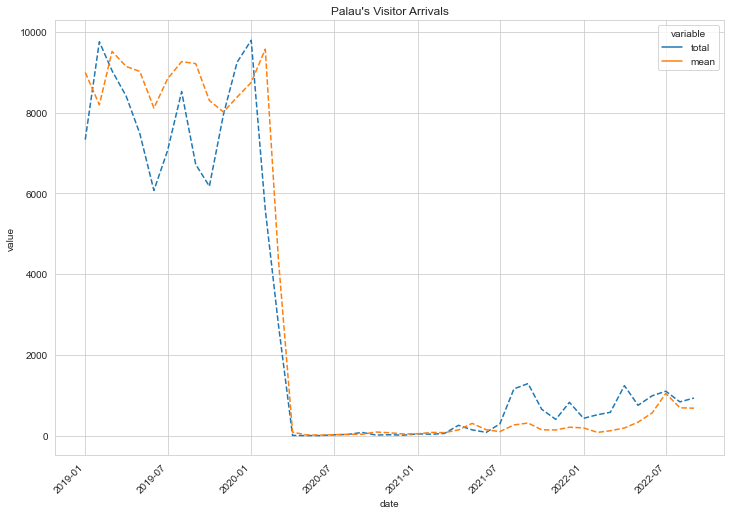

In [133]:
var_viz_df = palau_merged[["date", "total", "mean"]].melt(id_vars=["date"])

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=var_viz_df, x="date", y="value",
             hue="variable", linestyle="--")
plt.xticks(rotation=45, ha='right')
plt.title("Palau's Visitor Arrivals")
plt.show()

In [134]:
var_mean = mean_method(palau_merged["total"])
var_naive = naive_method(palau_merged["total"])

var_metrics = pd.DataFrame()
for idx, pred in enumerate([var_mean, var_naive]):
    df = pd.DataFrame(calculate_evaluation(palau_merged["total"], pred), index=[idx])
    var_metrics = pd.concat([var_metrics, df], axis=0)
    
var_metrics.index = ["mean", "naive"]

In [135]:
pred_metrics = calculate_evaluation(palau_merged["total"], palau_merged["mean"])
pred_metrics_df = pd.DataFrame(pred_metrics, index=["VAR"])
var_metrics = pd.concat([var_metrics, pred_metrics_df], axis=0)
var_metrics

,MSE,RMSE,MAE,MAPE
mean,1.219030e+07,3491.460526,3125.890370,12924.681771
naive,1.298621e+06,1139.570483,677.477273,1301.538952
VAR,1.149672e+06,1072.227515,674.455182,146.613436


## Ratio

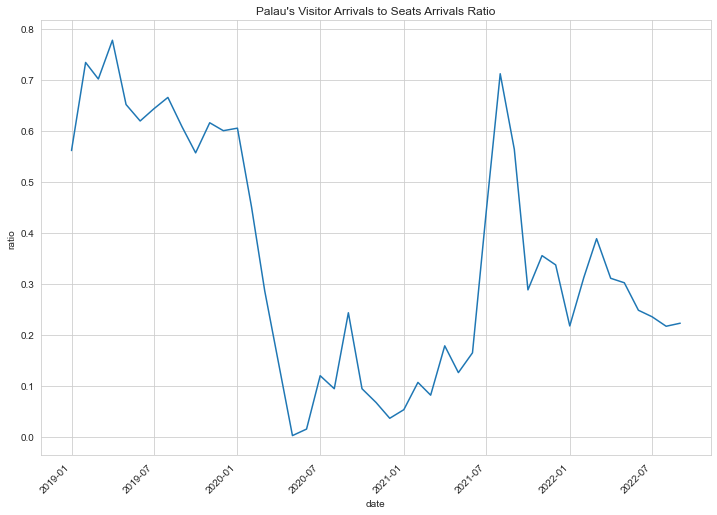

In [37]:
palau_merged["ratio"] = (palau_merged["total"])/(palau_merged["seats_arrivals_intl"])

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=palau_merged, x="date", y="ratio")
plt.xticks(rotation=45, ha='right')
plt.title("Palau's Visitor Arrivals to Seats Arrivals Ratio")
plt.show()

In [38]:
adj_ratio = []
for idx, ratio in enumerate(palau_merged["ratio"]):
    if ratio < 1:
        adj_ratio.append(ratio)
    else:
        ratio = ((palau_merged["ratio"][idx-1] + palau_merged["ratio"][idx+1]))/2
        adj_ratio.append(ratio)
        
palau_merged["adj_ratio"] = adj_ratio

In [39]:
get_adf_df(palau_merged, ["adj_ratio"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
adj_ratio,-2.259475,0.185371,1.0,43.0,-3.592504,-2.93155,-2.604066


In [40]:
temp = palau_merged[["ratio", "adj_ratio", "stringency_index", "date"]].reset_index()
temp["covid"] = (temp.date >= "2020-03-12")
temp["quarter"] = temp["date"].dt.quarter
# temp["stringency_index"] = temp["covid"] * temp["stringency_index"]
temp = (temp.merge(gt[["date", "palau travel"]], how="left", on="date")
            .rename({"palau travel": "palau_travel"}, axis=1))
temp.head(5)

,index,ratio,adj_ratio,stringency_index,date,covid,quarter,palau_travel
0,0,0.561695,0.561695,0.0,2019-01-01,False,1,0.194222
1,1,0.734282,0.734282,0.0,2019-02-01,False,1,0.282245
2,2,0.701865,0.701865,0.0,2019-03-01,False,1,0.286529
3,3,0.777809,0.777809,0.0,2019-04-01,False,2,0.338945
4,4,0.651848,0.651848,0.0,2019-05-01,False,2,0.168664


In [41]:
import statsmodels.formula.api as smf
res = smf.wls(
    formula="adj_ratio ~ covid * stringency_index + C(quarter) + palau_travel", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              adj_ratio   R-squared:                       0.762
Model:                            WLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     16.95
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           8.36e-10
Time:                        20:50:44   Log-Likelihood:                 34.253
No. Observations:                  45   AIC:                            -52.51
Df Residuals:                      37   BIC:                            -38.05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.4637      0.074      6.305      0.000       0.315       0.613
covid[T.True]                     -0.5484      0.105     -5.240      0.000      -0.760      -0.336
C(quarter)[T.2]                   -0.0496      0.055     -0.908      0.370      -0.160       0.061
C(quarter)[T.3]                    0.0487      0.056      0.865      0.392      -0.065       0.163
C(quarter)[T.4]                    0.0115      0.059      0.196      0.846      -0.107       0.130
stringency_index                  -0.0087      0.003     -2.855      0.007      -0.015      -0.003
covid[T.True]:stringency_index     0.0116      0.004      3.184      0.003       0.004       0.019
palau_travel                       0.5390      0.178      3.029      0.004       0.178       0.900
==============================================================================
Omnibus:                        6.243   Durbin-Watson:                   0.575
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.029
Skew:                           0.686   Prob(JB):                       0.0809
Kurtosis:                       3.894   Cond. No.                         574.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
ratio_pred = res.get_prediction().summary_frame()
ratio_stats = pd.concat([temp, ratio_pred], axis=1)
ratio_stats.head(5)

,index,ratio,adj_ratio,stringency_index,date,covid,quarter,palau_travel,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0,0.561695,0.561695,0.0,2019-01-01,False,1,0.194222,0.568387,0.051942,0.463144,0.673631,0.294774,0.842001
1,1,0.734282,0.734282,0.0,2019-02-01,False,1,0.282245,0.615828,0.047496,0.519592,0.712064,0.345551,0.886105
2,2,0.701865,0.701865,0.0,2019-03-01,False,1,0.286529,0.618136,0.047401,0.522092,0.714181,0.347928,0.888345
3,3,0.777809,0.777809,0.0,2019-04-01,False,2,0.338945,0.596816,0.048248,0.499057,0.694575,0.325993,0.867639
4,4,0.651848,0.651848,0.0,2019-05-01,False,2,0.168664,0.505042,0.059329,0.384831,0.625253,0.225330,0.784754


In [148]:
pred_mean = []
for idx, val in enumerate(ratio_stats["mean"]):
    pred = palau_merged["total"][idx] * ratio_stats["mean"][idx]
    pred_mean.append(pred)

array([4.16571128e+03, 6.00555392e+03, 5.58362682e+03, 5.01623940e+03,
       3.77670294e+03, 3.77430309e+03, 5.99161517e+03, 6.91965981e+03,
       4.52858168e+03, 3.63379525e+03, 4.65547067e+03, 5.80632359e+03,
       6.48581060e+03, 2.78846166e+03, 7.02484981e+02, 1.03612222e+00,
       1.62315578e-01, 3.82955159e-01, 5.40184147e+00, 7.48622760e+00,
       2.11359383e+01, 3.29311763e+00, 2.25856186e+00, 1.36494052e+00,
       6.69585673e+00, 4.92849579e+00, 1.20411375e+01, 6.07174527e+01,
       2.26418890e+01, 8.91939302e+00, 1.01452732e+02, 4.51110275e+02,
       3.20841278e+02, 1.35739506e+02, 1.06099080e+02, 2.02769647e+02,
       8.48893461e+01, 1.34724571e+02, 1.77734706e+02, 3.11911917e+02,
       1.89379462e+02, 2.49142109e+02, 2.47123772e+02, 1.50517953e+02,
       2.37670068e+02])

In [155]:
ratio_metrics = pd.DataFrame(calculate_evaluation(
    palau_merged["total"], np.array(pred_mean)), index=["Ratio"])

comb_metrics = pd.concat([var_metrics, ratio_metrics], axis=0)
comb_metrics

,MSE,RMSE,MAE,MAPE
mean,1.219030e+07,3491.460526,3125.890370,12924.681771
naive,1.298621e+06,1139.570483,677.477273,1301.538952
VAR,1.149672e+06,1072.227515,674.455182,146.613436
Ratio,2.956000e+06,1719.302106,1145.224144,64.940211


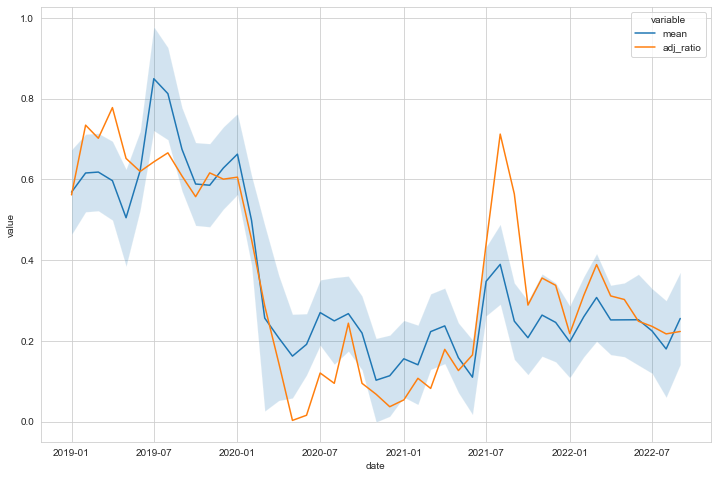

In [43]:
ratio_viz_df = ratio_stats[["mean", "adj_ratio", "date"]].melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.fill_between(data=ratio_stats, x="date", y1="mean_ci_lower", y2="mean_ci_upper", alpha=0.2)
plt.show()

In [44]:
stats = pd.DataFrame()
for num in range(-6, 0):
    res_test = smf.wls(
        formula="adj_ratio ~ covid * stringency_index + C(quarter) + palau_travel", data=temp[:int(num)]).fit()
    colname = "test_size_" + str(abs(num))
    predict_now = pd.DataFrame(res_test.predict(), columns=[colname])
    predict_test = pd.DataFrame(res_test.predict(temp[int(num):]),columns=[colname])
    stat = pd.concat([predict_now, predict_test], axis=0)
    stats = pd.concat([stats, stat], axis=1)
stats["date"] = palau_merged["date"]
stats["total"] = palau_merged["total"]

In [136]:
for col in stats.columns[:6]:
    stats[col] = palau_merged["seats_arrivals_intl"] * stats[col]
    
stats

,test_size_6,test_size_5,test_size_4,test_size_3,test_size_2,test_size_1,date,total
0,9.789718e+07,9.709398e+07,9.648480e+07,9.652768e+07,9.654248e+07,9.666504e+07,2019-01-01,7329.0
1,1.093757e+08,1.089326e+08,1.085975e+08,1.086210e+08,1.085734e+08,1.085279e+08,2019-02-01,9752.0
2,1.030742e+08,1.026759e+08,1.023747e+08,1.023958e+08,1.023482e+08,1.022976e+08,2019-03-01,9033.0
3,6.858576e+07,6.924544e+07,6.972112e+07,6.968933e+07,6.966829e+07,6.965363e+07,2019-04-01,8405.0
4,6.582406e+07,6.600595e+07,6.611486e+07,6.610919e+07,6.617635e+07,6.640878e+07,2019-05-01,7478.0
5,5.865629e+07,5.930969e+07,5.978524e+07,5.975314e+07,5.971788e+07,5.965659e+07,2019-06-01,6071.0
6,1.015891e+08,1.019947e+08,1.023501e+08,1.023218e+08,1.023783e+08,1.023333e+08,2019-07-01,7054.0
7,1.325715e+08,1.328419e+08,1.331114e+08,1.330880e+08,1.332106e+08,1.332743e+08,2019-08-01,8518.0
8,8.267290e+07,8.209350e+07,8.170023e+07,8.172473e+07,8.194218e+07,8.233564e+07,2019-09-01,6714.0
9,7.289370e+07,7.254326e+07,7.225458e+07,7.227648e+07,7.222628e+07,7.217062e+07,2019-10-01,6174.0


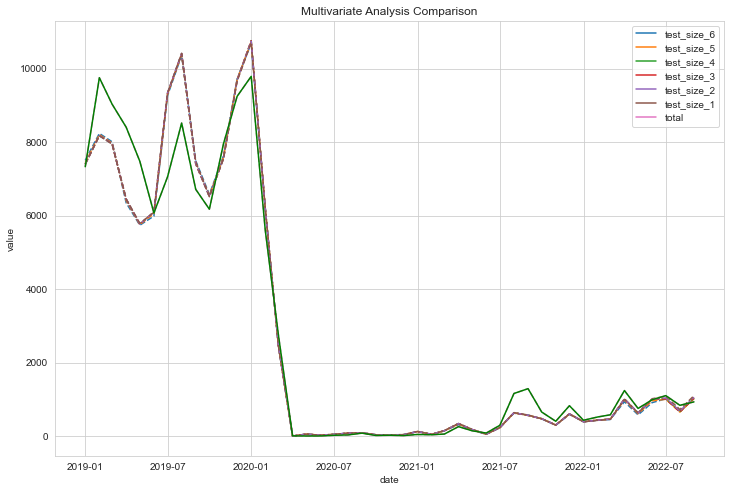

In [47]:
stats_viz_df = stats.melt(id_vars="date")

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=stats_viz_df, x="date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=palau_merged, x="date", y="total", color="green")
plt.title("Multivariate Analysis Comparison")
plt.show()